In [1]:
# Импорт зависимостей
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Вспомогательные функции

In [2]:
def segment_slope(d, size = 5):
    X, Y = d.iloc[:size, 0], d.iloc[:size, 1]
    X_mean, Y_mean = np.mean(X), np.mean(Y)
    n,d = 0,0
    for i in range(len(X)):
        n += (X[i] - X_mean)*(Y[i] - Y_mean)
        d += (X[i] - X_mean)**2
    b = n / d
    a = Y_mean - b*X_mean
    return a,b

linear = lambda a,b,t: a+b*t

TW_start_values = lambda y, yr: [0.5*(y[i]-yr[i]+y[i+4]-yr[i+4]) for i in range(4)]
HW_start_values = lambda y, yr: [0.5*(y[i]/yr[i]+y[i+4]/yr[i+4]) for i in range(4)]

## Определение оптимальных параметров сглаживания
Представим модели в виде функций, принимающих в качестве аргументов параметры сглаживание и возвращающих среднее значение ошибки аппроксимации

In [3]:
def r_squared(Y,YTH):
    Y_mean = np.mean(Y)
    SS_res = sum([(Y[i] - YTH[i])**2 for i in range(len(Y))])
    SS_tot = sum([(item - Y_mean)**2 for item in Y])
    coef = 1-(SS_res/SS_tot)
    return "{}%".format(round(coef*100,2))

def brown_model(alpha):
    data = pd.read_csv('data_series.csv')
    beta = 1 - alpha
    y = data.iloc[:,1]
    a0,a1 = segment_slope(data)
    yth = [sum([a0,a1])]
    e = [y[0]-yth[0]]
    e_appr = []
    for i in range(1,len(y)):
        a0 = a0 + a1 + (1- beta**2)*e[i-1]
        a1 = a1 + (1 - beta)**2*e[i-1]
        e.append(y[i]-sum([a0,a1]))
    for i in range(0,len(y)):
        e_appr.append(abs(e[i])/y[i])
    return np.mean(e_appr)

def holt_winters_model(params):
    l1, l2, l3 = params
    data = pd.read_csv('data_series.csv')
    a0,a1 = segment_slope(data)
    y_r = [linear(a0,a1,i) for i in range(1,9)] 
    y = data.iloc[:, 1]
    f = HW_start_values(y,y_r)
    e, e_appr = [], []
    for i in range(len(y)):
        yi = (a0+a1)*f[i]

        e.append(y[i]-yi)
        e_appr.append(abs(e[i])/y[i])
        temp = a0
        a0 = l1*(y[i]/f[i])+(1-l1)*(a0+a1)
        f.append(l2*(y[i]/a0)+(1-l2)*f[i])
        a1 = l3*(a0 - temp)+(1-l3)*a1
    for i in range(0,len(y)):
        e_appr.append(abs(e[i])/y[i])
    return np.mean(e_appr)
    
def tella_weige_model(params):
    l1, l2, l3 = params
    l4, l5, l6 = 1 - l1, 1- l2, 1- l3
    data = pd.read_csv('data_series.csv')
    a0,a1 = segment_slope(data)
    y_r = [linear(a0,a1,i) for i in range(1,9)] 
    y = data.iloc[:, 1]
    w = TW_start_values(y,y_r)
    e, e_appr = [], []
    for i in range(0,len(y)):
        yi = a0+a1+w[i]
        e.append(y[i]-yi)
        temp = a0
        a0 = l1*(y[i]-w[i])+l4*(a0+a1)
        a1 = l2*(a0-temp)+l5*a1
        w.append(l3*(y[i]-a0)+l6*w[i])
    for i in range(0,len(y)):
        e_appr.append(abs(e[i])/y[i])
    return np.mean(e_appr)


### С помощью функции minimize библиотеки Scipy найдем оптимальные параметры для каждой из моделей

In [4]:
bnds = ((0,1),(0,1),(0,1))

[0.34160103] 0.04932228888045559


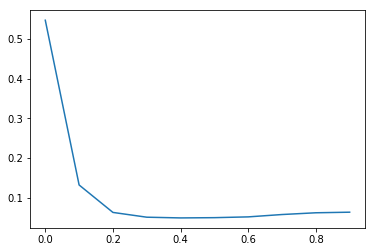

In [5]:
m = minimize(brown_model,[0.5])
print(m.x, m.fun)
x = np.arange(0,1,0.1)
plt.plot(x,brown_model(x))

In [6]:
m = minimize(holt_winters_model, [0.5,0.5,0.5], bounds = bnds)
print(m.x, m.fun)

[0.61100516 0.99999998 0.43328237] 0.03909849743144479


In [7]:
m = minimize(tella_weige_model,[0.5,0.5,0.5], bounds = bnds)
print(m.x, m.fun)

[0.63027654 0.49587441 1.        ] 0.040147537875843575
